# Acoustics equations with ExaHyPE 2 and the ClawPack Riemann solvers
 
A very simple solver of an acoustics equation benchmark. The interesting thing here (compared to Euler) is that we use ClawPack's point-wise Riemann solver for this problem.

In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") or f.startswith("output")]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use and we have to give it a name. There are a few more options that we omit here, i.e. we use the defaults.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "acoustics"], "exaclaw" )

## The simplest ExaClaw Finite Volumes solver

Our first step is to use a Finite Volumes solver. We refer them as ExaClaw solvers. ExaClaw is the research projects, where we promised to marry ExaHyPE and ClawPack. The actual softare is still ExaHyPE + ClawPack. 

In [4]:
patch_size     = 11
unknowns       = 2
auxiliary_variables = 2 
time_step_size = 0.0001
max_h          = 0.1
min_h          = 0.1


# This is where the Fortran file is located:
# /home/tobias/git/clawpack/riemann/src/rp1_acoustics_variable_ptwise.f90


my_solver = exahype2.solvers.fv.PointWiseClawPackFixedTimeStepSize(
  "Acoustics", patch_size, unknowns, auxiliary_variables, min_h, max_h, 0.0001,
  "rp1_ptwise", 
  ["/home/tobias/git/clawpack/riemann/src/rp1_acoustics_variable_ptwise.f90"]
)
project.add_solver( my_solver )

The two fundamental pieces of info we have to feed into the solver (besides the actual equation) are proper boundary and initial conditions. I use some factory/symbolic mechanisms here:

In [5]:
import exahype2.sympy

pde = exahype2.sympy.PDE(unknowns=2,auxiliary_variables=2,dimensions=2)

my_solver.set_implementation(
  boundary_conditions=pde.implementation_of_homogeneous_Neumann_BC()
)   
#    PDETerms.User_Defined_Implementation,refinement_criterion=PDETerms.User_Defined_Implementation,initial_conditions=PDETerms.User_Defined_Implementation):

## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [6]:
dimensions = 2

project.set_global_simulation_parameters(
  2,     # dimensions
  [0.0,0.0],  [1.0,1.0],
  0.005,        # end time
  0.0, time_step_size*10    # snapshots
)


## Generate a Peano 4 project

ExaHyPE's Python API does not really "do" something itself. It is a front-end to create and configure a Peano project. Peano in turn has its own Python API. In principle that allows us to use ExaHyPE 2 as a very high level code generator that we later on tweak. We can even use the outcome to inject further functionality that has never been supported by ExaHyPE 2 yet is available in Peano.

For the time being, none of these things is requires. We therefore simply ask ExaHyPE's API to give us a Peano project. This project is then told to generate the "real" C++ code and to translate. Every system will have a bespoke configuration, i.e. its own set of compilers, include paths, ... All of these ingredients have been chosen and tailored when we issued the configure script. Peano's Python API can parse the outcome of the configure instruction and use the same settings for the ExaHyPE/Peano project, too.

The generation can build up reasonably big data structures. If you work on a low-spec machine, you thus might want to tell the generate command to throw away all generated data after the C++ code has been built up.

In [7]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is g++
used Fortran compiler is gfortran


In [8]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated exaclaw-main.cpp
write ./Makefile
write ././AbstractAcoustics.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.h)
write ././AbstractAcoustics.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/fv/PointWiseClawPackFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/AcousticsQ.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.h.template)
write ./celldata/AcousticsQ.cpp (generated from template /home/tobias/git/Peano

This particular solver offers several implementation variants. It also can be fed with different memory allocation schemes for any dynamic memory allocation. Not all of them are C++ standard compliant, i.e. Clang for example might refuse to accept them.

With all project content generated and befilled with semantics, we can finally translate the code. Note that the above steps have actually produced a Makefile in our ExaHyPE 2 project folder. So we can either translate the project through the notebook, or we can switch to a terminal and invoke the translation manually.

Take care with the translation process if you want to use something fancy that is not active by default. If you have particular modules loaded or environment variables set, then all of these are required before you launch the notebook. On my own system, I need for example

<pre>
source /opt/intel/bin/iccvars.sh intel64
source /opt/intel/itac/2020.0.015/bin/itacvars.sh
source /opt/intel/impi/2019.6.166/intel64/bin/mpivars.sh
</pre>

to use the Intel toolchain. I experienced issues with notebooks where compile errors had not been displayed. Have a look at the terminal: It seems that cerr is not always piped into the notebook window. If that doesn't help, the only remaining option is to execute the whole notebook via ipython3.

In [9]:
parallel_builds = 8   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 8 ...
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o AbstractAcoustics.o AbstractAcoustics.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o Acoustics.o Acoustics.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o observers/SolverRepository.o observers/SolverRepository.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o celldata/AcousticsQ.o celldata/AcousticsQ.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o facedata/AcousticsQ.o facedata/AcousticsQ.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../../../src -c -o facedata/AcousticsQNew.o facedata/AcousticsQNew.cpp
g++ -std=c++0x -g -O2 -DPeanoDebug=2 -g -O2 -fopenmp  -DDimensions=2 -I. -I../.

## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [10]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...

run failed


True

We first grab and postprocess the data from the output file. This is ExaHyPE 2-specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [11]:
import exahype2.postprocessing

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

parse output.txt
file output.txt is invalid as number of time steps equals zero


In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on some of my local notebook servers, this causes a crash. So you have to test this yourself.

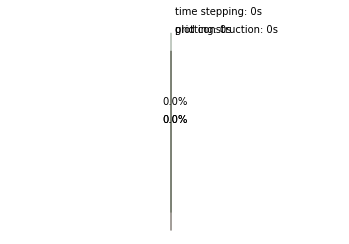

In [12]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

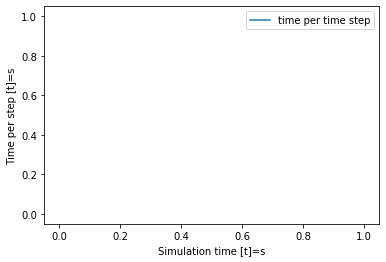

In [13]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Inspecting output files via Paraview

Paraview has a Jupyter notebook plugin now, and we can use it here to inspect the outcomes of the code directly: The installation process is described at https://gitlab.kitware.com/paraview/paraviewjupyterkernel/-/blob/main/README.md. It sounds great, but I haven't managed to make it run on my machines so far. The other option is to use a stand-alone executable to conver stuff into Paraview. This works if and only if you have configured Peano with Paraview support. I'm also currently working on a Python-based conversion, but this is work in progress. 

No matter which route we follow, we always first have to find out which files we have, as we need the filenames to trigger the postprocessing/vis. Per solver, we should have a file solution-XXX.peano-patch-file. The XXX is the solver name we have specified above.

In [14]:
!ls

AbstractAcoustics.cpp  exaclaw-main.h
AbstractAcoustics.h    exaclaw-main.o
AbstractAcoustics.o    exahype.log-filter
Acoustics.cpp	       facedata
Acoustics.h	       Makefile
Acoustics.ipynb        observers
Acoustics.o	       output.txt
celldata	       peano4
Constants.h	       solution-Acoustics.peano-patch-file
convert		       solution-Acoustics-tree-0-0.peano-patch-file
exaclaw-main.cpp


### Explicit conversion

This is an explicit, one-off conversion via an executable invocation. You can trigger this via the command line, i.e. via a manual invocation of the convert script. Alternatively, you can use Peano's Python convert wrapper:

In [15]:
import peano4.visualisation

peano_output_files = "solution-Acoustics"
convert = peano4.visualisation.Convert( peano_output_files, True )
convert.set_visualisation_tools_path( "../../../src/convert" )
convert.extract_fine_grid()
convert.convert_to_vtk()


inspect file solution-Acoustics ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-Acoustics.peano-patch-file']
found selectors {'AcousticsQ'}
extract fine grid from solution-Acoustics ... 
inspect file solution-Acoustics ... 
invoke ['../../../src/convert/convert', 'inspect', 'solution-Acoustics.peano-patch-file']
found selectors {'AcousticsQ-fine-grid', 'AcousticsQ'}
convert file solution-Acoustics into vtk (vtu binary format) ... 


Now you can invoke Paraview or VisIt in a separate window and study the outcome. Alternatively, you can use Paraview with its Paraview scripting environment. I select "Tools - Start Trace" and do my postprocessing. Upon hitting "Tools - End Trace" I obtain a Python script to render my stuff that I can insert here. You will have to modify it slightly, but the comments how to do so are all dumped by Paraview.

Alternatively, you can use the ipyparaview plugin as yet find it at https://github.com/Kitware/ipyparaview.git. The description of this one reads really cool, but I haven't managed yet to install it on my machine.